Data Visualization and Exploration
CPSC 5530
CRN 21428
Hunter Harris: zgt795
Assignment 4: Network & Tree Visualization 3

Import Libraries

In [328]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.preprocessing import MinMaxScaler

Read Data

In [329]:
# https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv
airports_df = pd.read_csv("airports.csv")
flights_df = pd.read_csv("flights.csv")

/home/hunter/anaconda3/envs/data/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inspect Data

In [330]:
print(airports_df)
print(flights_df.info())


    IATA_CODE                              AIRPORT  \
0         ABE  Lehigh Valley International Airport   
1         ABI             Abilene Regional Airport   
2         ABQ    Albuquerque International Sunport   
3         ABR            Aberdeen Regional Airport   
4         ABY   Southwest Georgia Regional Airport   
..        ...                                  ...   
317       WRG                     Wrangell Airport   
318       WYS               Westerly State Airport   
319       XNA  Northwest Arkansas Regional Airport   
320       YAK                      Yakutat Airport   
321       YUM           Yuma International Airport   

                               CITY STATE COUNTRY  LATITUDE  LONGITUDE  
0                         Allentown    PA     USA  40.65236  -75.44040  
1                           Abilene    TX     USA  32.41132  -99.68190  
2                       Albuquerque    NM     USA  35.04022 -106.60919  
3                          Aberdeen    SD     USA  45.44906

Data Cleaning

In [331]:
# Remove AK and Hawaii
airports_df = airports_df[(airports_df['STATE'] != 'AK') | (airports_df['STATE'] != 'HI')]
flights_df = flights_df.reset_index(drop=True)
flights_df = flights_df[pd.to_numeric(flights_df['ORIGIN_AIRPORT'], errors='coerce').isna()]
flights_df = flights_df[pd.to_numeric(flights_df['DESTINATION_AIRPORT'], errors='coerce').isna()]
flights_df = flights_df.reset_index(drop=True)

# Add count column
flights_df = flights_df.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).size().reset_index(name="Count")

# Add airport information from airports_df to flights_df
flights_df['ORIGIN_AIRPORT_Lat'] = flights_df['ORIGIN_AIRPORT'].map(airports_df.set_index('IATA_CODE')['LATITUDE'])
flights_df['ORIGIN_AIRPORT_Long'] = flights_df['ORIGIN_AIRPORT'].map(airports_df.set_index('IATA_CODE')['LONGITUDE'])
flights_df['DESTINATION_AIRPORT_Lat'] = flights_df['DESTINATION_AIRPORT'].map(airports_df.set_index('IATA_CODE')['LATITUDE'])
flights_df['DESTINATION_AIRPORT_Long'] = flights_df['DESTINATION_AIRPORT'].map(airports_df.set_index('IATA_CODE')['LONGITUDE'])
flights_df['State'] = flights_df['ORIGIN_AIRPORT'].map(airports_df.set_index('IATA_CODE')['STATE'])

# Drop null values
flights_df = flights_df.dropna()
flights_df = flights_df.reset_index(drop=True)

# Filter top 100 delays by Count
flights_df = flights_df.sort_values('Count', ascending= False).head(100)
flights_df = flights_df.reset_index(drop=True)

# Find the top airport per state
top_state = list(flights_df.groupby('State')['Count'].apply(lambda grp: grp.nlargest(1)))
flights_df = flights_df[flights_df['Count'].isin(top_state)]

# Normalize Count
flights_df['Count'] = MinMaxScaler().fit_transform(flights_df[['Count']])

Visualization

-122.37484, 37.619, -118.40807, 33.94254
-73.77893, 40.63975, -118.40807, 33.94254
-115.15233, 36.08036, -118.40807, 33.94254
-87.90446, 41.9796, -73.87261, 40.77724
-156.43046, 20.89865, -157.92241, 21.31869
-84.42694, 33.64044, -73.87261, 40.77724
-84.42694, 33.64044, -81.31603, 28.42889
-81.31603, 28.42889, -84.42694, 33.64044
-115.15233, 36.08036, -122.37484, 37.619
-97.0372, 32.89595, -87.90446, 41.9796
-122.30931, 47.44898, -118.40807, 33.94254
-71.00518, 42.36435, -77.03772, 38.85208
-77.03772, 38.85208, -71.00518, 42.36435
-112.00806, 33.43417, -118.40807, 33.94254
-122.37484, 37.619, -87.90446, 41.9796
-104.667, 39.85841, -112.00806, 33.43417
-75.24114, 39.87195, -84.42694, 33.64044
-149.99619, 61.17432, -122.30931, 47.44898
-80.94313, 35.21401, -84.42694, 33.64044
-95.27889, 29.64542, -96.85177, 32.84711
-93.21692, 44.88055, -87.90446, 41.9796
-111.97777, 40.78839, -104.667, 39.85841
-76.6682, 39.1754, -84.42694, 33.64044
-90.25803, 29.99339, -84.42694, 33.64044


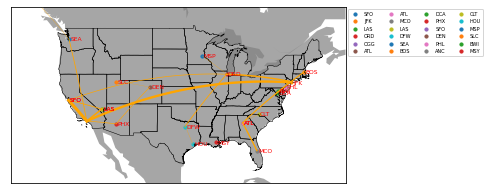

In [332]:
# create the map
map = Basemap(llcrnrlon=-135,
              llcrnrlat=22,
              urcrnrlon=-62,
              urcrnrlat=52,
              projection='merc')

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)
map.fillcontinents(color='grey', alpha=0.7, lake_color='grey')

# Loop on every pair of cities to add the connection
for row in flights_df.itertuples():
    print(f"{row.ORIGIN_AIRPORT_Long}, {row.ORIGIN_AIRPORT_Lat}, {row.DESTINATION_AIRPORT_Long}, {row.DESTINATION_AIRPORT_Lat}")
    map.drawgreatcircle(row.ORIGIN_AIRPORT_Long, row.ORIGIN_AIRPORT_Lat, row.DESTINATION_AIRPORT_Long, row.DESTINATION_AIRPORT_Lat, linewidth=3.0*row.Count, color='orange')
    plt.annotate(row.ORIGIN_AIRPORT, xy=map(row.ORIGIN_AIRPORT_Long+0.3, row.ORIGIN_AIRPORT_Lat), verticalalignment='center', fontsize=6, color='Red')
    map.scatter(row.ORIGIN_AIRPORT_Long, row.ORIGIN_AIRPORT_Lat, latlon=True, s=10, label=row.ORIGIN_AIRPORT)

# Add plot elements, Save, and show
plt.legend(ncol=4, bbox_to_anchor=(1, 1), prop={"size":5})
plt.savefig("US_Delays", dpi=1200, bbox_inches = 'tight')
plt.show()